<a href="https://colab.research.google.com/github/Abid-Ansari/Abid-Ansari.github.io/blob/main/Copy_of_Smile_Classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA SETUP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# mounting drive

Mounted at /content/drive


In [ ]:
!unzip '/content/happy_images.zip' -d '/content/drive/MyDrive/smiledet/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/smiledet/happy_images/03e43dd5-4d5b-41a8-b5bc-007c1ff940c6.jpg  
  inflating: /content/drive/MyDrive/smiledet/happy_images/884e8282-a4dd-4a43-970a-c8700d9f301e.jpg  
  inflating: /content/drive/MyDrive/smiledet/happy_images/04788cf5-6b2e-4e79-b306-f98d54bc5c4b.jpg  
  inflating: /content/drive/MyDrive/smiledet/happy_images/019f67b0-6a09-43d4-99f4-e3929ec1749b.jpg  
  inflating: /content/drive/MyDrive/smiledet/happy_images/38e961f3-9c59-4667-8cc8-ae913d8c099f.jpg  
  inflating: /content/drive/MyDrive/smiledet/happy_images/5bf510a5-2add-4f85-a222-e96b96419a3f.jpg  
  inflating: /content/drive/MyDrive/smiledet/happy_images/0502e3de-faa2-4abd-bcf8-46b2b33ac6fe.jpg  
  inflating: /content/drive/MyDrive/smiledet/happy_images/0e4ff859-79a3-4b51-b7a1-fe2e2f85c168.jpg  
  inflating: /content/drive/MyDrive/smiledet/happy_images/2cb2b9df-c6d6-463d-86bd-664a77ef73c3.jpg  
  inflating: /content/drive/MyDrive/smil

In [ ]:
!mv '/content/happy_images' '/content/drive/MyDrive/smiledet'
# !rm -rf '/content/drive/MyDrive/smiledet/data'
!cd '/content/'

mv: cannot stat '/content/happy_images': No such file or directory


# DATA Exploration

In [ ]:
#importing all the necessary pre requisite libraries

!pip install efficientnet-pytorch --quiet
!pip install fastprogress --quiet 
import numpy as np
import pandas as pd
import random
from random import randint
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from pathlib import Path
from torch.optim.optimizer import Optimizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import imread
from pylab import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from tqdm import tqdm_notebook as tqdm
import time
import copy
from efficientnet_pytorch import EfficientNet
!pip install pytorch_ranger --quiet
from pytorch_ranger import Ranger
import gc
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
def seed_everything(seed):
    #random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [ ]:
#Reading train csv file
df = pd.read_csv('/content/drive/MyDrive/smiledet/train.csv')
df.columns = ['img_id', 'smile']
df.head()

,img_id,smile
0,0403faa2-2d45-4779-b40a-794c220d3855,positive smile
1,1ba6784e-3684-4f76-81b7-504610a497e1,positive smile
2,675c87fb-bf50-481e-949d-07b5dc14b589,positive smile
3,02567fbb-1147-4186-8d7d-38611569fc06,NOT smile
4,02a42ebf-0683-4bc2-a616-e2ce8dc507cf,NOT smile


In [ ]:
#Reading test csv file
test_df = pd.read_csv('/content/drive/MyDrive/smiledet/test.csv')
test_df.columns = ['img_id','smile']
test_df.head()

,img_id,smile
0,1e53ec28-b4c0-4eef-ad91-4940f535d354,NOT smile
1,05f0d520-8e85-4490-a160-5a346fc21fd3,positive smile
2,0adf2567-b325-47a8-a2c9-83b34c021163,NOT smile
3,0df7e500-a1d0-44dd-923d-25809fa38611,NOT smile
4,03d812cd-27be-41b5-b2a1-856e4d1b66ab,NOT smile


In [ ]:
#Splitting training dataframe
train_df, val_df = train_test_split(df, test_size=0.2,random_state=42)
train_df.head()

,img_id,smile
289,06d92a63-1550-41b2-b771-d0a4ec54f80a,NOT smile
3649,0ceb4416-69ea-48fb-b80e-9e9c9e3f8591,NOT smile
4106,1c8ece9b-c2f8-40cd-ae85-b6cf1b751d12,NOT smile
3814,14c74c20-e6ff-49ee-a328-72006ed45b53,positive smile
535,5d0cad7d-eef5-4239-9baf-c1c157653cc5,positive smile


In [ ]:
print('train image count--',len(train_df),'\t test image count--',len(test_df),'\t val image count--',len(val_df),'\n')
train_df.smile.value_counts(normalize=True)

train image count-- 3864 	 test image count-- 1610 	 val image count-- 966 



NOT smile         0.693582
positive smile    0.206781
negative smile    0.099638
Name: smile, dtype: float64

#Labeling the target values to numeric values


In [ ]:

train_df['smile'] = train_df['smile'].map({"NOT smile": 0, 'positive smile': 1, 'negative smile': 2})
val_df['smile'] = val_df['smile'].map({"NOT smile": 0, 'positive smile': 1, 'negative smile': 2})
test_df['smile'] = test_df['smile'].map({"NOT smile": 0, 'positive smile': 1, 'negative smile': 2})
train_df.head()

,img_id,smile
289,06d92a63-1550-41b2-b771-d0a4ec54f80a,0
3649,0ceb4416-69ea-48fb-b80e-9e9c9e3f8591,0
4106,1c8ece9b-c2f8-40cd-ae85-b6cf1b751d12,0
3814,14c74c20-e6ff-49ee-a328-72006ed45b53,1
535,5d0cad7d-eef5-4239-9baf-c1c157653cc5,1


# Image w.r.t Label Visualisation

Samples with No smiles


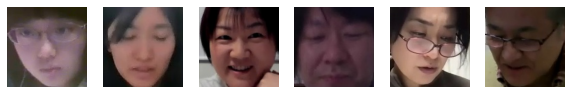

In [ ]:
print("Samples with No smiles")
imgs = train_df[train_df.smile==0]['img_id'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/drive/MyDrive/smiledet/happy_images')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}.jpg')
    ax.imshow(img)
    ax.axis('off')
plt.show()

Samples with positive smile


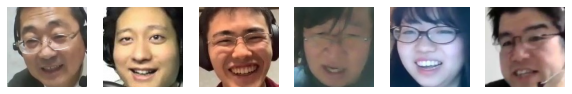

In [ ]:
print("Samples with positive smile")
imgs = train_df[train_df.smile==1]['img_id'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/drive/MyDrive/smiledet/happy_images')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}.jpg')
    ax.imshow(img)
    ax.axis('off')
plt.show()

Samples with negative smile


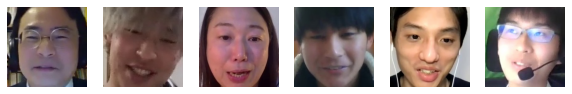

In [ ]:
print("Samples with negative smile")
imgs = train_df[train_df.smile==2]['img_id'].values
_, axs = plt.subplots(1, 6, figsize=(10, 4))
axs = axs.flatten()
path= Path('/content/drive/MyDrive/smiledet/happy_images')
for f_name,ax in zip(imgs[:10],axs):
    img = Image.open(path/f'{f_name}.jpg')
    ax.imshow(img)
    ax.axis('off')
plt.show()

# Building datasets and dataloaders 

In [ ]:
class dataset(Dataset):
  def __init__(self, csv_file, dir_path, phase):
    self.csv_file = csv_file
    self.dir_path = dir_path
    self.phase = phase
    self.transform = get_transforms(self.phase)

  def __len__(self):
    return len(self.csv_file)

  def __getitem__(self,idx):
    img_path = os.path.join(self.dir_path, self.csv_file.iloc[idx, 0])
    image = imread(img_path+'.jpg')
    label = self.csv_file.iloc[idx, 1]
    aug_img = self.transform(image=image)
    image = aug_img["image"]
    if self.phase=="test":
      return image, self.csv_file.iloc[idx, 0]
    return image,label

def get_transforms(phase):
    imagenet_stats = {'mean':[0.485, 0.456, 0.406], 'std':[0.229, 0.224, 0.225]}
    image_size=112
    train_tfms = A.Compose([
        A.Resize(image_size, image_size),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(),
        A.RandomGamma(p=0.75),
        A.CLAHE(clip_limit=4.0, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
        ToTensor(normalize=imagenet_stats)
        ])
    test_tfms = A.Compose([
        A.Resize(image_size, image_size),
        ToTensor(normalize=imagenet_stats)
        ])
    if phase=='train':
      return train_tfms
    else:
      return test_tfms

In [ ]:
### Creating train and test datasets
train_dataset = dataset(train_df,'/content/drive/MyDrive/smiledet/happy_images','train')
test_dataset = dataset(test_df,'/content/drive/MyDrive/smiledet/happy_images','test')
val_dataset = dataset(val_df,'/content/drive/MyDrive/smiledet/happy_images','val')
dataset_sizes={'train':len(train_dataset),'val':len(val_dataset),'test':len(test_dataset)}
print(dataset_sizes)

{'train': 3864, 'val': 966, 'test': 1610}


In [ ]:
# Creating DataLoaders for training, validation and testing
dataloader={}
dataloader['train'] = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
dataloader['test'] = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)
dataloader['val'] = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualising A Batch:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch size-- 16


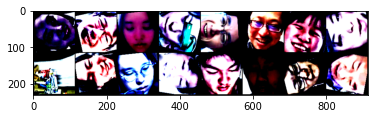

In [ ]:
### visualizing batches
def show_batch(sample_batch):
  img_batch,label_batch = sample_batch
  print('batch size--',len(img_batch))
  grid_border_size = 2
  grid = torchvision.utils.make_grid(img_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

print('Visualising A Batch:')

for i, sample_batch in enumerate(dataloader['train']):
  img, label = sample_batch
  if i==2:
    show_batch(sample_batch)
    break

In [ ]:
#Function to obtain train and validation loss
def plot_loss(train, val):
  x = np.arange(1, len(train)+1)
  plt.figure(figsize=(10,6))
  plt.plot(x, train, label='Training Loss')
  plt.plot(x, val, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Losses!')
  plt.legend(loc='upper right')
  plt.show()

# Trainer

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        #print(optimizer.lr)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            tk0 = tqdm(dataloader[phase], desc=phase, total=len(dataloader[phase]), position=0)
            for img_batch, labels in tk0:
                img_batch = img_batch.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(img_batch)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * img_batch.size(0)
                running_corrects += torch.sum(preds == labels.data)
                tk0.set_postfix(loss = (running_loss / ((i+1)*img_batch.size(0))))
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'val':
                scheduler.step(epoch_loss)
                val_history.append(epoch_loss)
            else:
              train_history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Saving model weights
            torch.save(model.state_dict(),f'/content/drive/MyDrive/smiledet/weights/last_wt_effb2_1.pth')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(),f'/content/drive/MyDrive/smiledet/weights/best_wt_effb2_1.pth')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    torch.save(model.state_dict(),f'/content/drive/MyDrive/smiledet/weights/best_wt_effb2_1.pth')
    return model, train_history, val_history

# Training model

In [ ]:
# Instantiating pretrained model
model = EfficientNet.from_pretrained('efficientnet-b2',num_classes=3)

device = torch.device("cuda")
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


In [ ]:
#Parameters of our train_model function

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr= 2e-3, weight_decay=0.002)
optimizer = Ranger(model.parameters(),lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.33,mode='max',patience=2,threshold=0.05, verbose=True)

gc.collect()

10237

#Here we are training the model

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


train:   0%|          | 0/121 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.1167 Acc: 0.3442


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 1.0511 Acc: 0.4431

Epoch 1/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 1.0050 Acc: 0.5445


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.9685 Acc: 0.6211

Epoch 2/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.8864 Acc: 0.6765


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.8573 Acc: 0.6977

Epoch 3/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.7907 Acc: 0.7101


val:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch     4: reducing learning rate of group 0 to 3.3000e-05.
val Loss: 0.7446 Acc: 0.7422

Epoch 4/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.7402 Acc: 0.7171


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.7291 Acc: 0.7453

Epoch 5/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.7222 Acc: 0.7332


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.7091 Acc: 0.7464

Epoch 6/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.7146 Acc: 0.7262


val:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch     7: reducing learning rate of group 0 to 1.0890e-05.
val Loss: 0.6905 Acc: 0.7557

Epoch 7/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.7001 Acc: 0.7324


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6850 Acc: 0.7609

Epoch 8/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.7381


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6776 Acc: 0.7629

Epoch 9/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6871 Acc: 0.7296


val:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch    10: reducing learning rate of group 0 to 3.5937e-06.
val Loss: 0.6719 Acc: 0.7650

Epoch 10/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6947 Acc: 0.7345


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6701 Acc: 0.7660

Epoch 11/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6865 Acc: 0.7440


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6695 Acc: 0.7660

Epoch 12/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6921 Acc: 0.7360


val:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch    13: reducing learning rate of group 0 to 1.1859e-06.
val Loss: 0.6682 Acc: 0.7650

Epoch 13/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6884 Acc: 0.7396


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6669 Acc: 0.7671

Epoch 14/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6804 Acc: 0.7404


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6665 Acc: 0.7660

Epoch 15/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6734 Acc: 0.7347


val:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch    16: reducing learning rate of group 0 to 3.9135e-07.
val Loss: 0.6649 Acc: 0.7650

Epoch 16/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6834 Acc: 0.7422


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6655 Acc: 0.7650

Epoch 17/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6808 Acc: 0.7407


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6652 Acc: 0.7660

Epoch 18/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6819 Acc: 0.7433


val:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch    19: reducing learning rate of group 0 to 1.2915e-07.
val Loss: 0.6653 Acc: 0.7660

Epoch 19/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6765 Acc: 0.7469


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6648 Acc: 0.7681

Epoch 20/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6878 Acc: 0.7329


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6654 Acc: 0.7640

Epoch 21/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6777 Acc: 0.7472


val:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch    22: reducing learning rate of group 0 to 4.2618e-08.
val Loss: 0.6657 Acc: 0.7671

Epoch 22/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6793 Acc: 0.7363


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6659 Acc: 0.7640

Epoch 23/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6833 Acc: 0.7381


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6658 Acc: 0.7660

Epoch 24/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6836 Acc: 0.7373


val:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch    25: reducing learning rate of group 0 to 1.4064e-08.
val Loss: 0.6658 Acc: 0.7660

Epoch 25/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6774 Acc: 0.7440


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6656 Acc: 0.7640

Epoch 26/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6846 Acc: 0.7412


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6662 Acc: 0.7660

Epoch 27/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6709 Acc: 0.7503


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6652 Acc: 0.7660

Epoch 28/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6812 Acc: 0.7384


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6656 Acc: 0.7671

Epoch 29/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6865 Acc: 0.7407


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6656 Acc: 0.7650

Epoch 30/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6840 Acc: 0.7384


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6643 Acc: 0.7671

Epoch 31/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6714 Acc: 0.7474


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6638 Acc: 0.7671

Epoch 32/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6824 Acc: 0.7433


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6664 Acc: 0.7650

Epoch 33/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6832 Acc: 0.7342


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6652 Acc: 0.7671

Epoch 34/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6885 Acc: 0.7358


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6639 Acc: 0.7681

Epoch 35/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6769 Acc: 0.7394


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6634 Acc: 0.7650

Epoch 36/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6820 Acc: 0.7386


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6643 Acc: 0.7650

Epoch 37/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6792 Acc: 0.7371


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6645 Acc: 0.7660

Epoch 38/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6784 Acc: 0.7407


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6648 Acc: 0.7671

Epoch 39/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6820 Acc: 0.7389


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6655 Acc: 0.7660

Epoch 40/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6846 Acc: 0.7409


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6648 Acc: 0.7650

Epoch 41/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6870 Acc: 0.7433


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6655 Acc: 0.7671

Epoch 42/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6766 Acc: 0.7417


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6659 Acc: 0.7660

Epoch 43/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6800 Acc: 0.7422


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6656 Acc: 0.7650

Epoch 44/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6844 Acc: 0.7451


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6660 Acc: 0.7660

Epoch 45/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6795 Acc: 0.7508


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6662 Acc: 0.7660

Epoch 46/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6776 Acc: 0.7438


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6653 Acc: 0.7660

Epoch 47/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6756 Acc: 0.7402


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6655 Acc: 0.7660

Epoch 48/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6853 Acc: 0.7396


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6663 Acc: 0.7650

Epoch 49/49
----------


train:   0%|          | 0/121 [00:00<?, ?it/s]

train Loss: 0.6857 Acc: 0.7407


val:   0%|          | 0/31 [00:00<?, ?it/s]

val Loss: 0.6649 Acc: 0.7660

Training complete in 37m 11s
Best val Acc: 0.768116


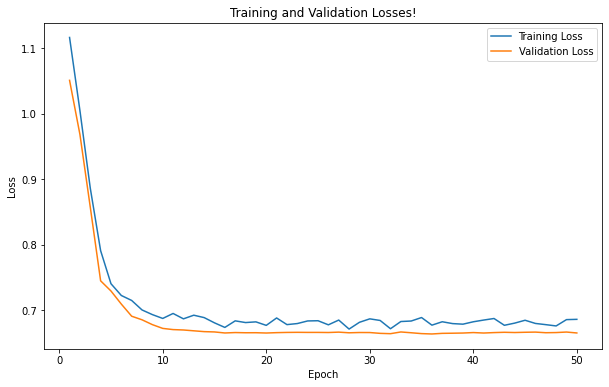

In [ ]:
trained_model, train_loss, val_loss = train_model(model, criterion, optimizer, scheduler, num_epochs=50)
plot_loss(train_loss, val_loss)

# Testing our Model 

In [ ]:
torch.cuda.empty_cache()
model.load_state_dict(torch.load('/content/drive/MyDrive/smiledet/weights/best_wt_effb4_1.pth'))

In [ ]:
model.eval()   # Set model to evaluate mode
prediction = torch.tensor([],dtype=torch.int64)
images = []#torch.tensor([],dtype=torch.int64)
prediction = prediction.to(device)
# Iterate over test data.
tk1 = tqdm(dataloader['test'], desc='Testing...', total=len(dataloader['test']), position=0)
for img_batch, img_id in tk1:
    img_batch = img_batch.to(device)
    with torch.set_grad_enabled(False):
      outputs = model(img_batch)
      _, preds = torch.max(outputs, 1)
    prediction = torch.cat((prediction,preds),0)
    for id in img_id:
      images.append(id)

print("Test set score: ", accuracy_score(np.array(test_df.iloc[:,1]),prediction.detach().cpu().numpy()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Testing...:   0%|          | 0/101 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test set score:  0.7751552795031056


#Prediction by our model


In [ ]:
df = {"img_id": images, "smile": prediction.cpu()}
output_df = pd.DataFrame(df)
output_df['smile'] = output_df['smile'].map({0:"NOT smile",  1:'positive smile', 2:'negative smile' })
output_df

,img_id,smile
0,1e53ec28-b4c0-4eef-ad91-4940f535d354,NOT smile
1,05f0d520-8e85-4490-a160-5a346fc21fd3,positive smile
2,0adf2567-b325-47a8-a2c9-83b34c021163,NOT smile
3,0df7e500-a1d0-44dd-923d-25809fa38611,NOT smile
4,03d812cd-27be-41b5-b2a1-856e4d1b66ab,NOT smile
...,...,...
1605,02d1f47d-56e4-4f42-8698-baa5bd637ba1,NOT smile
1606,180e76c5-3d05-4927-b4f8-d86dd11d22fb,positive smile
1607,0872c08e-7095-422b-b0a2-cc8976a25b0f,NOT smile
1608,6e5e8a31-d910-4801-a776-64ea836e76f1,NOT smile
